<a href="https://colab.research.google.com/github/BrunaFerreira/Coursera_Applied_Machine_Learning/blob/master/0_Classificacao_frutas_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Applied Machine Learning, Module 1:  A simple classification task

<a href = "https://www.coursera.org/learn/python-machine-learning/ungradedLab/2mey1/module-1-notebook/lab"> Link do Material do Curso </a>

In [1]:
#Aluna: Bruna Ferreira

### Import de bibliotecas e arquivos

In [2]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

caminho = '/content/drive/MyDrive/0_Cursos/1. Coursera/Applied Machine Learning/code/'
fruits = pd.read_table(caminho+'data/fruit_data_with_colors.txt')

In [3]:
# Insert the directory
import sys
sys.path.insert(0,caminho+'util')

In [4]:
# Import your module or file
from adspy_shared_utilities import plot_fruit_knn

### Nessa tabela:
- cada fruta é representada por uma linha
- Cada fruta tem seu <b> conjunto de caracteristicas (X) </b>: medidas, cores, etc. 
- Em aprendizado supervisionado, há uma coluna especifica que representa <b> variavel resposta (<i> target / label </i> ) </b>. 
Obs: Essa informação pode derivar de outras variaveis. 

In [5]:
fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


Para escala de cores da variavel `color_score`:
- Vermelho / Red ->  0.85 - 1.00
- Laranja / Orange ->  0.75 - 0.85
- Amarelo / Yellow ->  0.65 - 0.75

In [6]:
# Mapeamento do valor do rótulo da fruta para o nome da fruta para tornar os resultados mais fáceis de interpretar
lookup_fruit_name = dict(zip(fruits.fruit_label.unique(), fruits.fruit_name.unique()))   
lookup_fruit_name

{1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

O arquivo contém a massa, a altura e a largura de uma seleção de laranjas, limões e maçãs. As alturas foram medidas ao longo do miolo da fruta. As larguras foram as maiores larguras perpendiculares à altura.

### <b>Objetivo </b>
- Contruir um classificador para prever o tipo correto de fruta, a partir de qualquer observação de caracteristicas. 

### Obs 1: Nunca utilizar os dados de treinamento para teste. 
- O classificador deve ser capaz de identificar diferentes amostras de  frutas, não apenas as que estão no conjunto d etreinamento. 
- O classificador poderia apenas <b> memorizar </b> o rótulo de cada amostra do conjunto de treinamento, ao invés de aprender.  

Afim de estimar a performance do classificador para amostras futuras, dividiremos os dados em dois conjuntos:
-  <b>Conjunto de Treinamento</b> : usado para treinar o classificador 
-  <b>Conjunto de Teste</b>: usado para avaliar o classificador treinado

<img src = "https://github.com/BrunaFerreira/Coursera_Applied_Machine_Learning/blob/master/images/fig_1.png?raw=true" width = 900px />

In [7]:
from matplotlib import cm

# Separando caracteristicas 
# Chamado "Espçao de Caracteristicas"
X = fruits [['height', 'width', 'mass', 'color_score']]

# Separando variavel resposta
y = fruits ['fruit_label']

# Separando conjunto de treinamento e de teste
# divisão padrão : 75% (treino) , 25% (Teste)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 0)

### Analise dos Dados 
Analisar os dados antes é importante para ter uma ideia de quais tipos de <b> limpeza </b> ou <b> pré-processamento </b> serão necessárias. 

Você pode encontrar:
- inconsistencias especificas, como valor errado, unidades de medidas incorretas.
- Valores ausentes / <i>Missing Values </i>. 

#### Obs 2: Problema pode ser solucionado sem <i>Machine Learning</i>. 

### Importancia de visualização dos dados 
- ter ideia dos intervalos das caracteristicas
- identificar outliers
- observar o quão separados ou próximos estão os objetos no espaço de caracteristicas

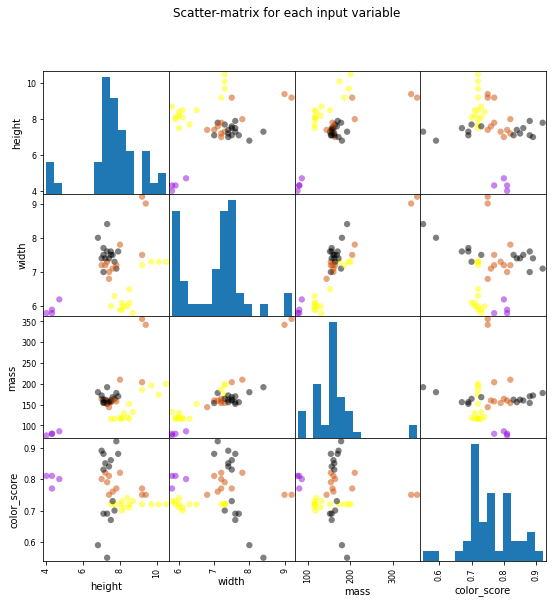

In [8]:
from matplotlib import cm
from pandas.plotting._misc import scatter_matrix

cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X_train, c= y_train, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap=cmap)
plt.suptitle('Scatter-matrix for each input variable')
plt.savefig('fruits_scatter_matrix')

Text(0.5, 0, 'color_score')

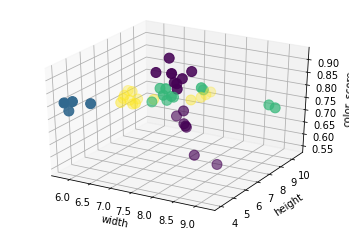

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_train['width'], X_train['height'], X_train['color_score'], c = y_train, marker = 'o', s=100)
ax.set_xlabel('width')
ax.set_ylabel('height')
ax.set_zlabel('color_score')

Na imagem acima:
- Amarelo = Limão (Lemon)
- Verde = Laranja (Orange)
- Azul  = Mandarin
- Roxo = Maçã (Apple)

### Algoritmo KNN (k-nearest neighbors) 
- pode ser usado para classificação e para regressão. 
- algoritmo supervisionado.
- baseado em memória. Os dados do conjunto de treinamento são armazenados e usados para classificar novos exemplos. 
- <b> k</b> refere-se ao número de vizinhos mais próximos que o classificador irá buscar para fazer fazer as previsões. 

### KNN Classificador - Etapas

Dado um conjunto de dados de treinamento X_train com seus rótulos y_train, e dada uma nova instancia x_test a ser classificada:
1. Encontre as instancias mais similares (X_NN) a x_test que estão em X_train. 
> Ao receber um elemento, nunca visto, para ser classificado, o classificador KNN vai olhar para o conjunto de dados de treinamento já memorizados. E vai escolher os k exemplos que possuem caracteristicas mais similares ao novo exemplo.

2. Busque os rótulos y_NN das instancias X_NN.
3. Prever o rótulo de x_test combinando os rótulos y_NN
> Um exemplo de forma de combinar esses votos é através do voto marjoritário (mais frequente). 

<b>Fronteira de Decisão</b>: Os pontos em um lado dessa linha são mapeados como uma classe, e os outros do outro lado como outra classe. Ou seja, a linha que separa suas classes. 

Tipicamente o valor de k é ímpar. 

### KNN Classificador - Definições iniciais

1. Métrica de distância 
    - Importante para selecionar os vizinhos mais próximos de forma apropriada. 
    - Ex: Distancia euclidiana ou distancia da linha reta. 
    - Distancia Euclidiana é um caso especial da métrica Minkowski, onde o parametro p = 2.
2. Quantos vizinhos mais próximos (K) serão utilizados?
3. Atribuição opcional de  mais peso (influência) a alguns vizinhos comparados a outros.  
    - Ex: Os vizinhos mais próximos tem voto com maior peso que outros vizinhos. 
4. Método para combinar as classes dos vizinhos. 
    - Especificar como os rótulos serão combinados para gerar previsão. 

### Instanciando KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5 )

### Treinando Classificador (fit the estimator) usando os dados de treinamento

In [11]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

<b> Estimadores </b> : Os objetos dessa classe possuem o método `fit` que pega os dados de treinamento e modifica os estados dos classificadores habilitando previsão ao terminar o treinamento.  
- Atualiza o estado do parâmetro e da variavel, nesse caso guarda os dados de treinamento para uso futuro. 

### Estimar acurácia do classificador para dados futuros, usando dados de teste

<b> Acurácia </b> : é a fração dos itens de teste, do qual os rótulos foram classificados corretamente. 

In [12]:
knn.score(X_test, y_test)

0.5333333333333333

### Usando modelo classificador KNN para prever objetos desconhecidos

In [13]:
fruit_prediction = knn.predict([[20, 4.3, 5.5, 0.7]])

In [14]:
lookup_fruit_name[fruit_prediction[0]]

'mandarin'

### Exibindo a fronteira de Decisão do classificador KNN

In [15]:
#plot_fruit_knn(X_train.to_numpy(), y_train.to_numpy(), 5, 'uniform')

#'Uniform significa tratar todos os dados de forma igual'

### Quanto o valor de K afeta a acurácia do Classificador?

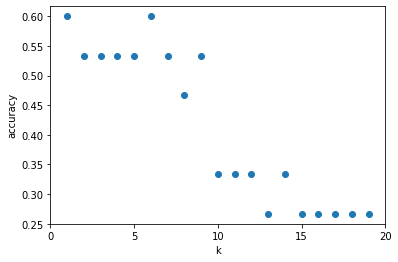

In [16]:
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors= k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);

Altos valores de k levam a pior acurácia, para esse conjunto de dados e distribuição. 